# Tutorial 3 – Training Nonadiabatic Couplings


When focusing solely on the ground state, machine learning force fields are usually created by learning the energies and forces (energy gradients) associated with it. 
However, when developing machine learning force fields for multiple electronic states, encompassing both the ground and excited states, it becomes necessary not only to account for the energies and forces of each specific state, but also to consider the interactions or couplings between these electronic states. 
These couplings arise from factors like changes in the dipole moment or geometry.

## NN Challenges: Taming Tricky Properties

### The Phase Problem

The energy of a given electronic state can be derived from its wavefunction $\Psi_i(\mathbf{R}$) and the potential energy operator $\hat{V}$ according to

\begin{equation}
E_i = \left\langle\Psi_i(\mathbf{R}) | \hat{V} | \Psi_i(\mathbf{R}) \right\rangle ~. 
\end{equation}

This approach is applicable for predicting both, energies of ground and excited states.
However, there are additional important properties that emerge when two distinct electronic states are coupled. An example is the transition dipole moment ($\mathbf{\mu}_{ij}$), which is influenced by the dipole operator ($\mu$), expressed as

\begin{equation}
\displaystyle \mathbf{\mu}_{ij}(\mathbf{R}) = \left\langle \Psi_{i}(\mathbf{R}) | \hat{\mathbf{\mu}} | \Psi_{j}(\mathbf{R}) \right\rangle ~.
\end{equation}

Another crucial property, particularly relevant for nonadiabatic molecular dynamics simulations, is the nonadiabatic coupling vector ($\mathbf{C}_{ij}$), defined as

\begin{equation}
\displaystyle \mathbf{C}_{ij} = \left\langle \Psi_{i}(\mathbf{R}) | \nabla_{\mathbf{R}} \Psi_{j}(\mathbf{R}) \right\rangle ~.
\end{equation}

Wavefunctions ($\Psi_i$) are subject to phase variations, leading to arbitrary signs. 
Consequently, properties related to different states, *i.e.* $\mathbf{\mu}_{ij}$ and $\mathbf{C}_{ij}$, also possess arbitrary signs. 
This sign issue can lead neural network predictions to cancel out, as the same input (geometry) might yield opposite sign outputs. To mitigate this numerical challenge, a phase-less loss function is employed for such properties. The phase-less variant of the mean absolute error ($\mathsf{MAE}$, $n=1$) and mean squared error ($\mathsf{MSE}$, $n=2$) are defined as

\begin{equation}
\displaystyle \mathcal{L}_p = \frac{1}{3N} \sum_{k}^{N_{c}} \min_i\left( \sum_{l,m} \left| Q_k^{ref} 1_2^{\top} - Q_k^{NN} 1_2^{\top} \odot \begin{pmatrix}
        1 \\ -1 
    \end{pmatrix}^{\top}~\right|_{lm}^n \right) ~,
\end{equation}

where $Q^{NN}$ represents the predicted and $Q^{ref}$ the reference values.
Summation is performed using the indices $k$, $l$ and $m$, whereas the values of $k$ range from 1 to the number of couplings ($N_c$), $l$ ranges from 1 to $N_{atoms}$ and $m$ ranges from 1 to 3 (xyz-direction, vectorial property).

In simpler terms, the $\mathsf{MAE}$ and $\mathsf{MSE}$ can be expressed as

\begin{equation}
\displaystyle \mathsf{MAE} = \min\left(|| Q^{ref} - Q^{NN} ||, || Q^{ref} + Q^{NN} || \right)~\text{and},
\end{equation}

\begin{equation}
\displaystyle \mathsf{MSE} = \min\left(|| Q^{ref} - Q^{NN} ||_2, || Q^{ref} + Q^{NN} ||_2 \right)~.
\end{equation}

Notably, for properties like transition dipoles and nonadiabatic couplings, which are vectorial in nature, the '$-$' or '$+$' sign in these equations pertains to the entire vector.

### The singularity problem

The effects that go beyond the Born-Oppenheimer approximation and nonadiabatic transitions between distinct electronic states are determined by nonadiabatic couplings denoted as $\mathbf{C}_{ji}$. 
These couplings can be expressed in a Hellmann-Feynman-like form, which reads as

\begin{equation}
    \mathbf{C}_{ij} = \left\langle \Psi_i(\mathbf{R}) | \nabla_{\mathbf{R}} \Psi_j(\mathbf{R}) \right\rangle = \frac{\left\langle \Psi_i(\mathbf{R}) | \nabla_{\mathbf{R}}\hat{H} | \Psi_j(\mathbf{R}) \right\rangle}{E_j - E_i} ~~~~~~\text{with}~ j > i~.
\end{equation}

This equation reveals that the nonadiabatic couplings become singular when approaching the intersection of two electronic states, *i.e.*, as $E_j - E_i \rightarrow 0$. 
This singularity poses challenges for neural network (NN) predictions. 
To mitigate this, we choose to train the NN with respect to $\mathbf{C}_{ij}\left(E_j - E_i\right)$, which we refer to as smoothed nonadiabatic couplings, denoted as $\mathbf{C}_{ij}^s$. 
These smoothed couplings are well-defined properties and are utilized in this tutorial as part of the database (```smooth_nacs```). 
It's worth noting that an alternative approach involves calculating $\mathbf{C}_{ij}^s$ during training, either using reference energies or NN-predicted energies. 
However, this method is computationally more demanding and less robust, especially when relying on NN-predicted energies.


## Load and Preprocess Data

To process and prepare data for training, we begin with importing all relevant packages and specifying the location of an existing ASE (Atomic Simulation Envirnonment) database. Please return to the first tutorial to learn how to convert original quantum chemical data into an ASE database.

In [1]:
import sys, os

from ase.db import connect

import torch
import torchmetrics
import pytorch_lightning as pl
import schnetpack as spk

import spainn
import spainn.properties as sp

Here, we want to train a model for three electronic states, namely $S_0$, $S_1$, and $S_2$.
Therefore, we train the NN with respect to the energies ($E_i$), forces (-$\nabla_{\mathbf{R}}E_i$), and smoothed nonadiabatic couplings ($\mathbf{C}_{ij}^s$).
In the following way, one can check, if the desired properties, *i.e.* the property keys `energy`, `forces`, and `smooth_nacs` are stored in the databse:

In [2]:
dbname = 'spainn_ch2nh2+.db'
datapath = os.path.join(os.getcwd(), 'data', dbname)
db = connect(datapath)

db.get(1).data.keys()

dict_keys(['energy', 'socs', 'forces', 'nacs', 'smooth_nacs', 'dipoles'])

Next the data is loaded form the `spainn_ch2nh2+.db` from the data folder.
For this we use the ``SPAINN`` class that inhertits the ``AtomsDataModule`` class provided by SchNetPack.

In [3]:
%rm ./train/split.npz

data_module = sp.SPAINN(
    n_states = 3, # singlet states 0, 1, 2
    n_nacs = 3, # couplings: 01, 02, 12
    datapath=datapath, # path to database
    batch_size=2,
    num_train=0.7, # 70% of databse for training
    num_val=0.1, # 10% of database for validation
    split_file=os.path.join('train', 'split.npz'),
    splitting=spk.data.splitting.RandomSplit(),
    load_properties=['energy', 'forces', 'smooth_nacs'],
    transforms=[
        # remove mean of energy in every electronic state
        spk.transform.RemoveOffsets(sp.SPAINN.energy, remove_mean=True, remove_atomrefs=False),
        spk.transform.ASENeighborList(cutoff=5.0),
        spk.transform.CastTo32(),
            ],
)

# setup everything
data_module.prepare_data()
data_module.setup()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 128.19it/s]

{'energy': (tensor([-15.7648, -15.7358, -15.7207], dtype=torch.float64), tensor([0.0103, 0.0065, 0.0053], dtype=torch.float64))}


To check, if the desired properties, namely `energy`, `forces`, and `smooth_nacs` are loaded to the datamodule, you can access the keys and shapes from the data module in the following way:

In [4]:
properties = data_module.dataset[0]
print('Loaded properties:\n', 
      *[str(i)+'\t'+str(properties[i].shape)+'\n' for i in properties.keys() if not i.startswith('_')])


Loaded properties:
 energy	torch.Size([1, 3])
 forces	torch.Size([6, 3, 3])
 smooth_nacs	torch.Size([6, 3, 3])



## Define the Model

After the data preparation, we now build a model for training the NN PESs. 
This is done in three core steps:

1. Defining input modules (pairwise distance)
2. Building a representation (PaiNN representation)
3. Defining output modules (module for `energy`, `forces` and `smooth_nacs`)

### Defining Input Modules

Here we use a paiwise distance as input module and use the PaiNN representation.

In [5]:
n_atom_basis = 50
cutoff = 10.0

# input module: calculates pairwise distances between atoms
pairwise_distance = spk.atomistic.PairwiseDistances()

# radial basis for convolution
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)

### Building a Representation

In the previous tutorial, we trained the NN with respect to $E_i$ and $-\nabla_{\mathbf{R}}E_i$ using the SchNet representation.
Using this representation, allows energy predictions that are invariant to rotations and force predictions that are equivariant to rotations (as we learn the forces from the negative gradient of the energy).
However, SchNet provides nonadiabatic coupling predictions that are invariant to rotations.
However, we would like to represent the atomwise contribution of the nonadiabatic couplings within the chemical environment by equivariant vectors.
For this reason, we rely here on the PaiNN representation, which allows the following predictions with respect to rotation:

- `energy`: invariant
- `forces`: equivariant
- `smooth_nacs`: equivariant


In [6]:
# PaiNN Representation
painn = spk.representation.PaiNN(
    radial_basis = radial_basis,
    n_atom_basis=n_atom_basis,
    n_interactions=6,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
)

### Defining Output Modules

As we want to model energies, forces and nonadiabatic couplings, we need three output modules. 
We will use an `Atomwise` module to predict the energies of the electronic states as implemented in SchNetPack, by adjusting the number of outputs to the number of electronic states, *i.e.*, `n_out=3`.
To describe the forces as derivative of the energy for multiple electronic states, we use the `Forces` module of **SPaiNN**, that computes the negative derivative of the energy for every electronic state with respect to the nuclear positions.
For the nonadiabatic couplings, we use the `Nacs` module of **SPaiNN** with `n_out` being the number of couplings ($N_C$), according to:

\begin{equation}
\displaystyle N_C = \frac{1}{2} N_{\text{singlets}} \left( N_{\text{singlets}} - 1\right)
\end{equation}

In [7]:
pred_energy = spainn.model.Atomwise(
    n_in=n_atom_basis,
    n_out=3, # number of electronic states (S0, S1, S2)
    n_layers=3,
)

pred_forces = spainn.model.Forces()

pred_nacs = spainn.model.Nacs(
    n_in=n_atom_basis,
    n_out=3, # number of couplings (C01, C02, C12)
    nac_key=sp.SPAINN.smooth_nacs,
    use_vector_repr=True # False for SchNet
)

In the following the representation as well as input and output modules are assembled to a NN potential. 
In this step, we also specify a post-processor, that adds the mean, which we removed as offset in the data pre-processing, to the predictions to obtain energies on the scale of the reference data. 
This is done with the `AddMultipleOffsets` post-processor of **SPaiNN**.

In [8]:
nnpot = spk.model.NeuralNetworkPotential(
    representation=painn,
    input_modules=[pairwise_distance],
    output_modules=[pred_energy, pred_forces, pred_nacs],
    input_dtype_str='float32',
    do_postprocessing=True,
    postprocessors=[
        spk.transform.CastTo64(),
        spk.transform.AddOffsets(spainn.SPAINN.energy, add_mean=True, add_atomrefs=False),
    ],
)

## Training the Model

For training a model, the training task, *i.e.*, model, loss-functions and optimizers have to be defined. First the output of the models are connected to loss functions using the `ModelOutput` class of SchNetPack. Here, the combined loss function reads as:

\begin{equation}
\displaystyle \mathcal{L}(E_{ref},\mathbf{F}_{ref},\mathbf{C}_{ref},E_{NN},\mathbf{F}_{NN},\mathbf{C}_{NN}) = -\frac{1}{n_{train}}\sum_{n=1}^{n_{train}} \left( \rho_1 \mathcal{L}_E + \rho_2 \mathcal{L}_F + \rho_3 \mathcal{L}_C \right)
\end{equation}

The loss weights $\rho_k$ are introduced to control the tradeoff between energies, forces and nonadiabatic couplings.

For predicting energies and forces, we employ the standard mean-square error loss functions, that read as
\begin{equation}
\displaystyle \mathcal{L}_E(E_{ref},E_{NN}) = ||E_{ref} - E_{NN}||_2~,~\text{and}
\end{equation}

\begin{equation}
\displaystyle \mathcal{L}_F(\mathbf{F_{ref}},-\nabla_{\mathbf{R}}E_{NN}) = ||\mathbf{F_{ref}} - \left( -\nabla_{\mathbf{R}}E_{NN}\right) ||_2~.
\end{equation}

For predicting the nonadiabadtic couplings, we employ the phase-less loss-function ```PhaseLoss``` of **SpaiNN**.
As described above, the phase vector of every wavefunction $\Psi_i(\mathbf{R})$ has an arbitrary sign and resultingly, the nonadiabatic couplings, will also have an arbitrary sign.
This sign problem will cause NN predictions to collapse to zero, as the same input, *i.e.* geometry can lead to opposite signs of output.
To overcome this numerical bottleneck, we use the ```PhaseLoss``` loss function, which is a phase-less version of the mean absolute error, and can be expressed as

\begin{equation}
\displaystyle \mathcal{L}_C = \min\left(|| \mathbf{\hat{C}}_{ij}^{s} - \mathbf{C}_{ij}^{s} ||, || \mathbf{\hat{C}}_{ij}^{s} + \mathbf{C}_{ij}^{s} || \right) ~,
\end{equation}

where $\mathbf{\hat{C}}_{ij}^s$ represents the reference and $\mathbf{C}_{ij}^s$ the predicted smoothed nonadiabatic couplings.



In [9]:
output_energy = spk.task.ModelOutput(
    name=spainn.SPAINN.energy,
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1.0, #0.05,
    metrics={
        "MSE": torchmetrics.MeanSquaredError(),
    },
)

output_forces = spk.task.ModelOutput(
    name=spainn.SPAINN.forces,
    loss_fn=torch.nn.MSELoss(),
    loss_weight=1.0, #0.10,
    metrics={
        "MSE": torchmetrics.MeanSquaredError(),
    },
)

output_nacs = spk.task.ModelOutput(
    name=sp.SPAINN.smooth_nacs,
    # MSE loss function for phase properties 
    loss_fn=spainn.loss.PhaseLossAtomisticMSE(atoms=6),
    loss_weight=1.0, #0.85,
    metrics={
        "MSE": spainn.metric.PhaseAtomisticMSE(atoms=6),
    },
)

In the next step we set up the task and trainer, *i.e.*, a PyTorch Lightning `Trainer` and train for 100 epochs.

In [10]:
import warnings; warnings.simplefilter('ignore')

task = spk.task.AtomisticTask(
    model=nnpot,
    outputs=[output_energy, output_forces, output_nacs],
    optimizer_cls=torch.optim.AdamW,
    optimizer_args={"lr": 1e-4},
    scheduler_monitor="val_loss",
)

modelpath = os.path.join(os.getcwd(), 'train')
callbacks = [
    spk.train.ModelCheckpoint(
        model_path=os.path.join(modelpath, "best_model_E_F_C"),
        save_top_k=1,
        monitor="val_loss"
    )
]

trainer = pl.Trainer(
    log_every_n_steps=1,
    callbacks=callbacks,
    logger=pl.loggers.TensorBoardLogger(save_dir=modelpath),
    default_root_dir=modelpath,
    max_epochs=100, # for testing, we restrict the number of epochs
)

trainer.fit(task, datamodule=data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type                   | Params
---------------------------------------------------
0 | model   | NeuralNetworkPotential | 202 K 
1 | outputs | ModuleList             | 0     
---------------------------------------------------
202 K     Trainable params
0         Non-trainable params
202 K     Total params
0.811     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## Using the Model

To use the trained model, we load the `best_model_E_F_C` file and, *e.g.*, evaluate on the test data.

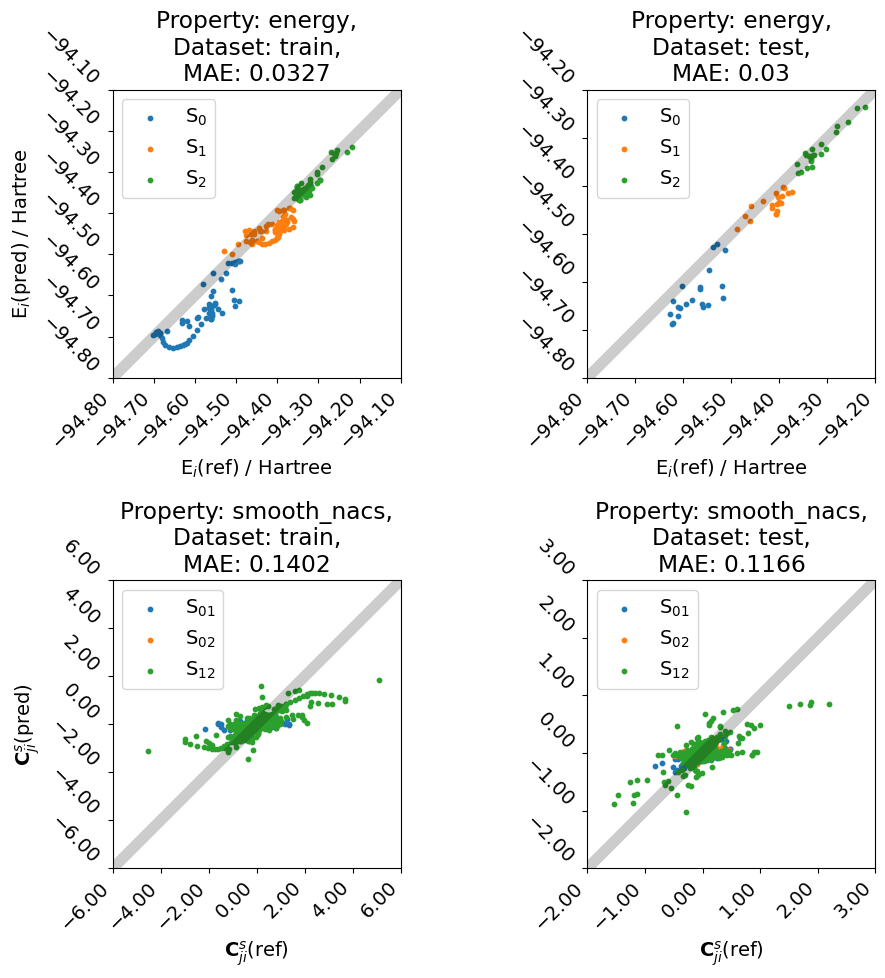

In [11]:
import spainn.plotting as sp

plotter = sp.PlotMAE(
  database = datapath,
  split_file = os.path.join(os.getcwd(), 'train', 'split.npz'),
  model_file = os.path.join(os.getcwd(), 'train', 'best_model_E_F_C'),
  cutoff = cutoff,
  properties2plot=['energy', 'smooth_nacs'],
  subset2plot=['train', 'test'],
)

plotter.plot()